# Import All Essential Packages


In [45]:
# load packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import math, itertools, os, shapely
from shapely.geometry import Polygon, Point

from scipy import ndimage as ndi
from skimage import feature, io
from skimage.transform import rotate
from skimage.feature import match_template, peak_local_max
import cv2
import random
from ortools.linear_solver import pywraplp as OR

This code is for attempting to fit as many chairs as possible within an empty room given constraints including a 12x10 foot teachers box and 6 feet between all included seats. It requires a to scale diagram of the classroom, an example chair and a scale.

# Step 1: Modify the Parameters
Change the Parameters to work for the rume you are solving for.

In [169]:
Screen_Height=1080 #The Height of Your Physical Screen In Pixels
Screen_Width=1920 #The Width of Your Physical Screen In Pixels
floor = 'BARTON1F.jpg' # you need the path to the image file on YOUR computer
floor2 = 'BARTON1F.jpg' # another image with identifiable distances
solution_name="BARTON-1F-sol"
feetyardStick=20 #how many feet long the yardstick is
floorU = cv2.imread(floor, cv2.IMREAD_UNCHANGED)
floor_str = floor
floor2U = cv2.imread(floor2, cv2.IMREAD_UNCHANGED)
floor2_str = floor2
t_box = 'top'    # t box starts from: 'top', 'bottom', 'left', or 'right'. The Wall that the teacher zone will generate from
perimeterft=0.5 #The perimeter space you want to have for chairs from the walls.
x_factor=1 #The frequency with which you want to place chairs in the x direction in a grid pattern. (1 means placing one chair when it ould be 6 feet from the chair before it)
y_factor=1 #The frequency with which you want to place chairs in the y direction in a grid pattern. (1 means placing one chair when it ould be 6 feet from the chair before it)
chairsRandom=1000 #The amount of chairs to randomly place. For testing Purposes
chairsRandomHex=0 #The amount of chairs to randomly place in the hexagonal pattern. This allows you to add more chairs than would fit in a hexagonal grid.
x_border = 0 
y_border = 0
desk_border = 0
Shift_Above_Teacher_Zone=False #True tells the code to move all chair placements to start ahead of the teacher.
rotate=False # If True, the defined chair shape will be rotated 90 degrees.
Rotated_Other=False # If True, the chair shape will become an octagon that encompasses all possible rotations of the defined chair.
Scale_Orientation="Vertical" #If "Vertical", will change to define the scale vertically.

The cell below sets up to allow scrolling in large images, designates which image should be writable and which should be non writable, and resets all polygons in order to allow for redesignation

In [127]:
if floorU.shape[0] > Screen_Height:
    height=floorU.shape[0]
    Window_Height=Screen_Height
else:
    height=Screen_Height
    Window_Height=floorU.shape[0]-1
if floorU.shape[1]>Screen_Width:
    width=floorU.shape[1]
    Window_Width=Screen_Width
else:
    width=Screen_Width
    Window_Width=floorU.shape[1]-1
NonWritableImage=cv2.imread(floor)
WritableImage=cv2.imread(floor)
Doorways=[]

In [128]:
# get lh, .., uw from full set of 4 coordinates
def getCoords(rect):
    """
    Takes an np.array with coords of rectangle.
    Returns max / min height / width
    """
    lw = min(rect[:,0])
    uw = max(rect[:,0])
    lh = min(rect[:,1])
    uh = max(rect[:,1])

    return(lw, uw, lh, uh)

# SETUP

## Scale Selection
Click one corner of the scale and drag to the opposite corner before releasing. This will draw a red box around the scale and let the computer calculate the conversions between pixels and feet on the image.


In [129]:
ref=[]
avger=[]
coords=(0,0)
clone=WritableImage.copy()
cv2.namedWindow("Scale Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Scale Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Scale Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Scale Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        count+=1
    elif event == cv2.EVENT_LBUTTONUP:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
        cv2.imshow("Scale Selection", rect)
cv2.setMouseCallback("Scale Selection",set_coords)
while True:
    cv2.resizeWindow("Scale Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Scale Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Scale Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Scale Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        WritableImage = clone.copy()
        ref=[]
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break
for r in range(len(ref)//2):
    x1 = ref[2*r][0]
    y1 = ref[2*r][1]
    x2 = ref[2*r+1][0]
    y2 = ref[2*r+1][1]
    if(x1>x2):
        xTemp=x1
        x1=x2
        x2=xTemp
    if(y1>y2):
        yTemp=y1
        y1=y2
        y2=yTemp
    ys = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    avger.append(ys)
x1avg=0
x2avg=0
y1avg=0
y2avg=0
for ys in avger:
    x1avg+=ys[0][0]
    x2avg+=ys[1][0]
    y1avg+=ys[0][1]
    y2avg+=ys[2][1]
x1avg=x1avg/len(avger)
x2avg=x2avg/len(avger)
y1avg=y1avg/len(avger)
y2avg=y2avg/len(avger)
print(x2avg)
print(x1avg)
print(y2avg)
print(y1avg)
if Scale_Orientation=="Vertical":
    Temp1=x1avg
    x1avg=y1avg
    y1avg=Temp1
    Temp2=x2avg
    x2avg=y2avg
    y2avg=Temp2
print(y2avg)
print(y1avg)
print(x2avg)
print(x1avg)

stick_points=np.array([(x1avg,y1avg),(x2avg,y1avg),(x2avg,y2avg),(x1avg,y2avg)])
Stick=Polygon(stick_points)
feet6=6.0/feetyardStick*(x2avg-x1avg)
feet10=5/3*feet6
print(str(feetyardStick)+' feet = %d pixels.' % (x2avg-x1avg))
print(' 6 feet = %.1f pixels' % feet6)

234.0
225.0
2575.0
2453.0
234.0
225.0
2575.0
2453.0
20 feet = 122 pixels.
 6 feet = 36.6 pixels


## Check the Scale 
Click around the image to draw a 3 foot radius circle centered on the point you clicked. This can be used to check the validity of the scale on the image.


In [130]:
#Check Scale
cv2.namedWindow("ScaleCheck",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("ScaleCheck",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
CheckPoints=[]
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "ScaleCheck", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "ScaleCheck", scrollWidth, (width-Screen_Width),TrackbarChange)
ref = []
def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "ScaleCheck"), y+cv2.getTrackbarPos("Hscroll", "ScaleCheck")))
        print((x,y))
        door=cv2.circle(WritableImage,ref[-1],int(feet6/2),(0,255,0),1,1)
        cv2.imshow("ScaleCheck", door)
cv2.setMouseCallback("ScaleCheck", get_coords)
while True:
    cv2.resizeWindow("ScaleCheck", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "ScaleCheck")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "ScaleCheck")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("ScaleCheck", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
CheckPoints=ref


(773, 487)


## Designate the Classroom Area
Click two opposite corners of the classroom to designate the classroom to the code. Chairs will only be placed within the classroom.

In [167]:
ref=[]
avger=[]
refresh=[]
coords=(0,0)
WritableClone=WritableImage.copy()
cv2.namedWindow("Classroom Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Classroom Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
xmin=99999
xmax=0
ymin=99999
ymax=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Classroom Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Classroom Selection", scrollWidth, (width-Screen_Width),TrackbarChange)

def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Classroom Selection"), y+cv2.getTrackbarPos("Hscroll", "Classroom Selection")))
        refresh.append('r')
    if event==cv2.EVENT_RBUTTONDOWN:
        del ref[-1]
        refresh.append('r')

cv2.setMouseCallback("Classroom Selection",set_coords)

while True:
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Classroom Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Classroom Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Classroom Selection", Image)
    
    if len(refresh)>=1:
        WritableImage=WritableClone.copy()
        
        for point in ref:
            if point[0]<=xmin:
                xmin=point[0]
            if point[1]<=ymin:
                ymin=point[1]
            if point[0]>=xmax:
                xmax=point[0]
            if point[1]>=ymax:
                ymax=point[1]
        
        cv2.rectangle(WritableImage, (xmin, ymin), (xmax,ymax), (255,0,0), 1)
        refresh=[]
    
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, restart
    if key == ord("r"):
        ref=[]
        xmin=99999
        xmax=0
        ymin=99999
        ymax=0
        refresh.append('r')
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break

Classroom = np.array([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
x_edge=(xmin,xmax)
y_edge=(ymin,ymax)
WritableImage=WritableClone.copy()
rect = cv2.rectangle(WritableImage, (xmin, ymin), (xmax,ymax), (255,0,0), 1)

## Designate the Chair
If Rotated_Other is False, click too opposite corners of the chair to designate it. This will generate a centered rectangle that signifies each chair.

If Rotated_OTher is True, click each corner of the chair. The code will find the longest distance between the clicked points, set that as the diameter of a circle, then generate an octagon around it that can encompass the chair at any rotation to signify each chair.

In [132]:
ref=[]
avger=[]
coords=(0,0)
clone=WritableImage.copy()
cv2.namedWindow("Chair Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Chair Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Chair Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Chair Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        if Rotated_Other!=True:
            if len(ref)<2:
                ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
                count+=1
        else:
            ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
    elif event == cv2.EVENT_LBUTTONUP:
        if(len(ref)==2):
            if Rotated_Other!=True:
                rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
                cv2.imshow("Chair Selection", rect)
                print(ref)
        circ=cv2.circle(WritableImage, ref[-1], 2, (0,0,255), 2)
        cv2.imshow("Chair Selection", circ)
cv2.setMouseCallback("Chair Selection",set_coords)
while True:
    cv2.resizeWindow("Chair Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Chair Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Chair Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Chair Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        WritableImage = clone.copy()
        ref=[]
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break
if Rotated_Other!=True:
    for r in range(len(ref)//2):
        x1 = ref[2*r][0]
        y1 = ref[2*r][1]
        x2 = ref[2*r+1][0]
        y2 = ref[2*r+1][1]
        if(x1>x2):
            xTemp=x1
            x1=x2
            x2=xTemp
        if(y1>y2):
            yTemp=y1
            y1=y2
            y2=yTemp
        Chair = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    if rotate == True:
        temp1 = x1
        x1 = y1
        y1 = temp1
        temp2 = x2
        x2 = y2
        y2 = temp2
    Polygon_Width=x2-x1
    Polygon_Height=y2-y1
    arr = np.array([(-int(Polygon_Width/2),-int(Polygon_Height/2)), (-int(Polygon_Width/2),int(Polygon_Height/2)),(int(Polygon_Width/2),int(Polygon_Height/2)),(int(Polygon_Width/2),-int(Polygon_Height/2))])
if Rotated_Other==True:
    diameter=-1
    for point in ref:
        for point2 in ref:
            TempDiameter=((point2[0]-point[0])**2+(point2[1]-point[1])**2)**0.5
            if TempDiameter>diameter:
                diameter=TempDiameter
    angle=math.radians(22.5)
    arr=np.array([(-diameter/2*math.tan(angle),diameter/2),(diameter/2*math.tan(angle),diameter/2),(diameter/2,diameter/2*math.tan(angle)),(diameter/2,-diameter/2*math.tan(angle)),(diameter/2*math.tan(angle),-diameter/2),(-diameter/2*math.tan(angle),-diameter/2),(-diameter/2,-diameter/2*math.tan(angle)),(-diameter/2, diameter/2*math.tan(angle))])
    Polygon_Width=diameter+1
    Polygon_Height=diameter+1
print(arr)
p = Polygon(arr)
WritableImage=clone.copy()
rect = cv2.rectangle(WritableImage, ref[0], ref[1], (0, 0, 255), 1)

[(1287, 512), (1271, 526)]
[[-8 -7]
 [-8  7]
 [ 8  7]
 [ 8 -7]]


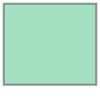

In [133]:
p

## Designate Non Seatable Zones
Click on the corners aroud any area that cannot have seats in it. This cell can be run multiple times to add multiple such areas. Any seat generated in such an area will automatically not be designated as one that can be seated.

In [202]:
#Define the Polygon
cv2.namedWindow("Doorway Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Doorway Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
WritableClone=WritableImage.copy()
ref = []
refresh=[]

def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Doorway Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Doorway Selection", scrollWidth, (width-Screen_Width),TrackbarChange)

def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Doorway Selection"), y+cv2.getTrackbarPos("Hscroll", "Doorway Selection")))
        refresh.append('r')
    elif event==cv2.EVENT_RBUTTONDOWN:
        del ref[-1]
        refresh.append('r')

cv2.setMouseCallback("Doorway Selection", get_coords)

while True:
    
    #These lines are what allow the scrolling
    ScrollHeight=cv2.getTrackbarPos("Hscroll", "Doorway Selection")
    ScrollWidth=cv2.getTrackbarPos("Wscroll", "Doorway Selection")
    ShownImage = np.array([(ScrollWidth,ScrollHeight),(ScrollWidth+width,ScrollHeight),(ScrollWidth+width,ScrollHeight+height),(ScrollWidth,ScrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Doorway Selection", Image)
    
    #Refreshes the polygon on the image if there has been an update to it
    if len(refresh)>=1:
        WritableImage=WritableClone.copy()
        if len(ref)>=2:
            for i in range(len(ref)):
                cv2.line(WritableImage,ref[i],ref[i-1],(255, 0, 255), 1)
        elif len(ref)==1:
            cv2.circle(WritableImage,ref[0],2,(255,0,255),2)
        refresh=[]
    
    #Listen for key presses
    key = cv2.waitKey(1) & 0xFF
    
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
        
    # if the key 'f' is pressed, finalize the polygon and get ready to make a new one
    if key==ord("f") and len(ref)>=3:
        Doorway=np.array(ref)
        doorway = Polygon(Doorway)
        Doorways.append(doorway)
        for item in range(len(ref)):
            del ref[-1]
        WritableClone=WritableImage.copy()
    
    # if the key 'd' is pressed, completely delete the polygon being worked on.
    if key==ord("d"):
        for item in range(len(ref)):
            del ref[-1]
        refresh.append('r')

print(Doorways)

[<shapely.geometry.polygon.Polygon object at 0x0000022F145DBA48>, <shapely.geometry.polygon.Polygon object at 0x0000022F22C05D08>, <shapely.geometry.polygon.Polygon object at 0x0000022F0FDD5D48>]


## Designate The Teacher Zone
Click a point along the chosen wall (From the parameters passed above) to generate a box that extends out by 10 feet and 6 feet to either side. If Shift_Above_Teacher_Zone is false, chairs will be able to generate to the sides of the box. Otherwise, chairs will only be able to generate in front of the box. Any chair that generates within the boundaries of the box will automatically not be designated as seatable

In [170]:
#Define the teacher area
cv2.namedWindow("Teacher Box Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Teacher Box Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Teacher Box Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Teacher Box Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
ref = []
def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        if ref != []:
            del ref[-1]
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Teacher Box Selection"), y+cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")))
    elif event == cv2.EVENT_LBUTTONUP:
        if t_box == 'top' or t_box == 'bottom':
            if t_box == 'top':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]-feet6),int(temp[1])))
                ref.append((int(temp[0]+feet6),int(temp[1]+feet10)))
            if t_box == 'bottom':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]-feet6),int(temp[1]-feet10)))
                ref.append((int(temp[0]+feet6),int(temp[1])))
        if t_box == 'left' or t_box == 'right':
            if t_box == 'left':
                temp_x = math.floor(ref[0][0] + feet10)
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]),int(temp[1]+feet6)))
                ref.append((int(temp[0]+feet10),int(temp[1]-feet6)))
            if t_box == 'right':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]),int(temp[1]+feet6)))
                ref.append((int(temp[0]-feet10),int(temp[1]-feet6)))
        print(ref)
        rect = cv2.rectangle(WritableImage, ref[0], ref[1], (0, 255, 0), 1)
        cv2.imshow("Teacher Box Selection", rect)
cv2.setMouseCallback("Teacher Box Selection", get_coords)
while True:
    cv2.resizeWindow("Teacher Box Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Teacher Box Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Teacher Box Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
nogozone = np.array([ref[0], (ref[0][0], ref[1][1]), ref[1], (ref[1][0], ref[0][1])])
zone = Polygon(nogozone)

[(1044, 494), (1117, 555)]


# Adjustments
Adjusts the inputted information to allow the later portions of the code attempt to solve for a maximal amount of seats

Shifts the classroom designation so that the sides of the chair generate within the room and perimeterft feet away from the walls.

In [171]:
x_edge_perimeter=(int(x_edge[0]+perimeterft/6*feet6+Polygon_Width/2), int(x_edge[1]-perimeterft/6*feet6-Polygon_Width/2))
y_edge_perimeter=(int(y_edge[0]+perimeterft/6*feet6+Polygon_Height/2), int(y_edge[1]-perimeterft/6*feet6-Polygon_Height/2))
print(x_edge_perimeter)
print(y_edge_perimeter)

(770, 1140)
(575, 2590)


Show the adjusted designated area for checking purposes.

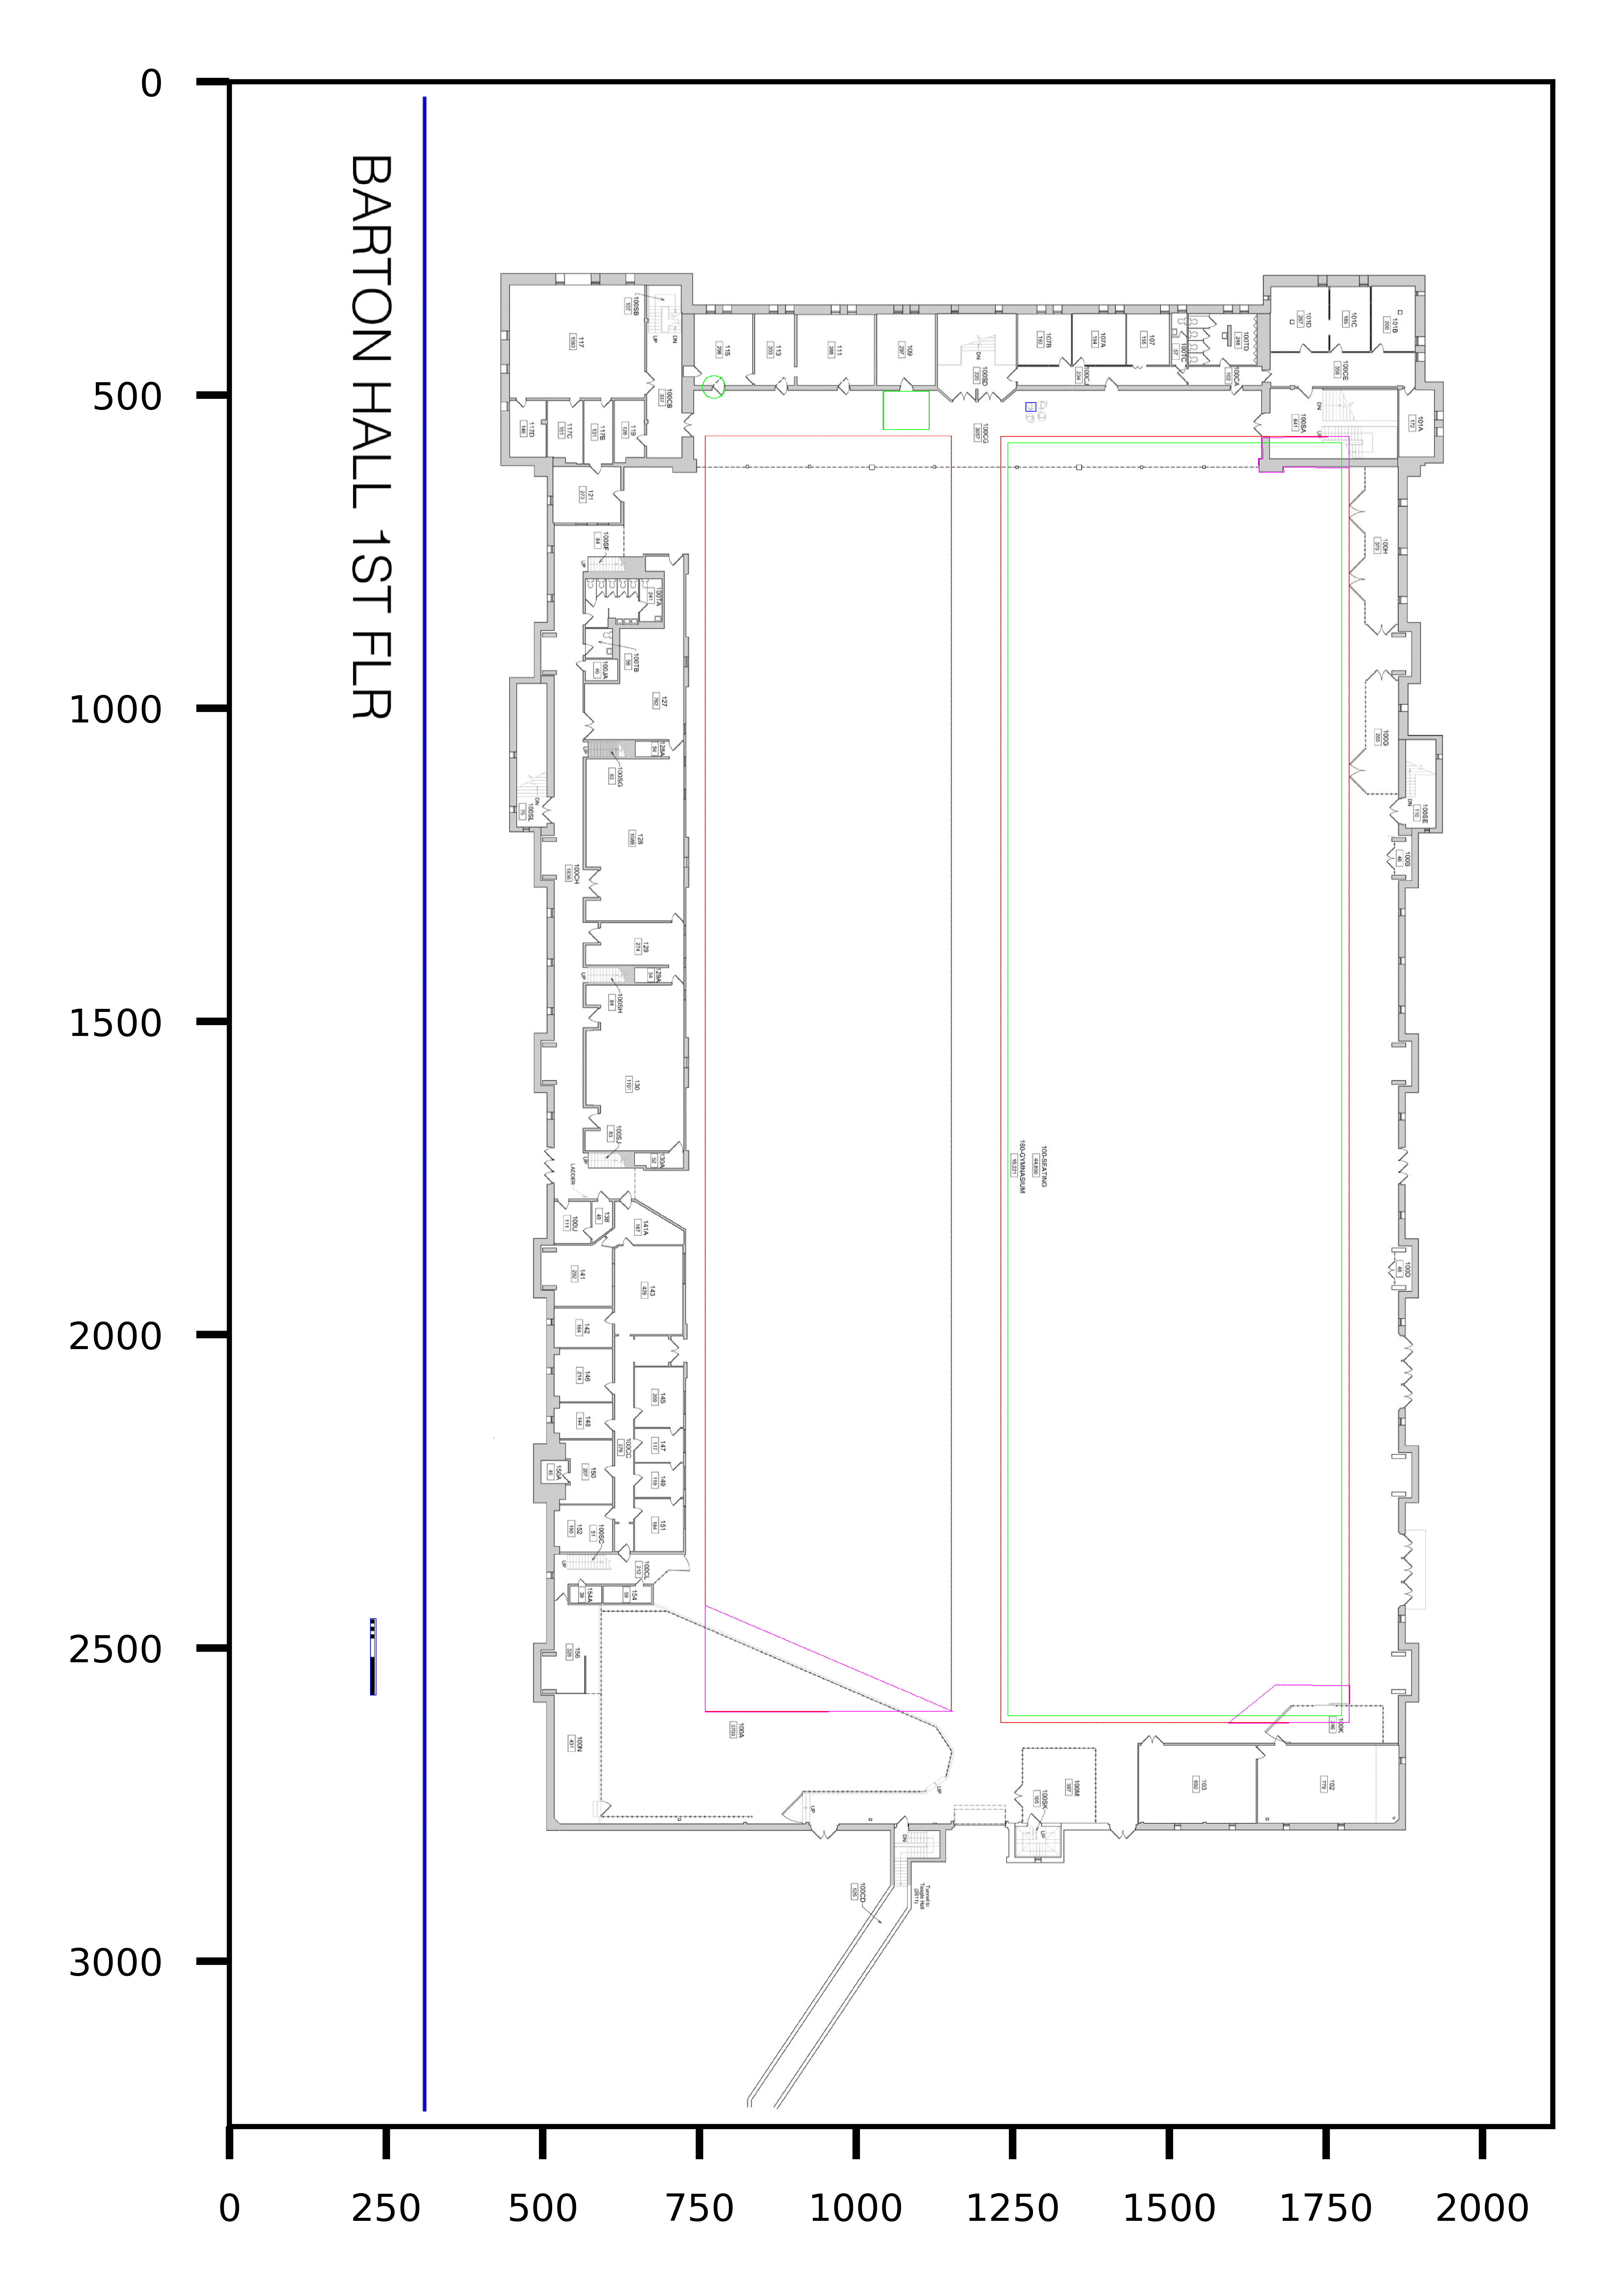

In [172]:
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=2000)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    
ax.imshow(WritableImage)

Shifts the Seatable area based off of the teacher zone if Shift_Above_Teacher_Zone is true. Designates PZWidth and PZHeight for use in later parts of the code and shows the adjusted image below.

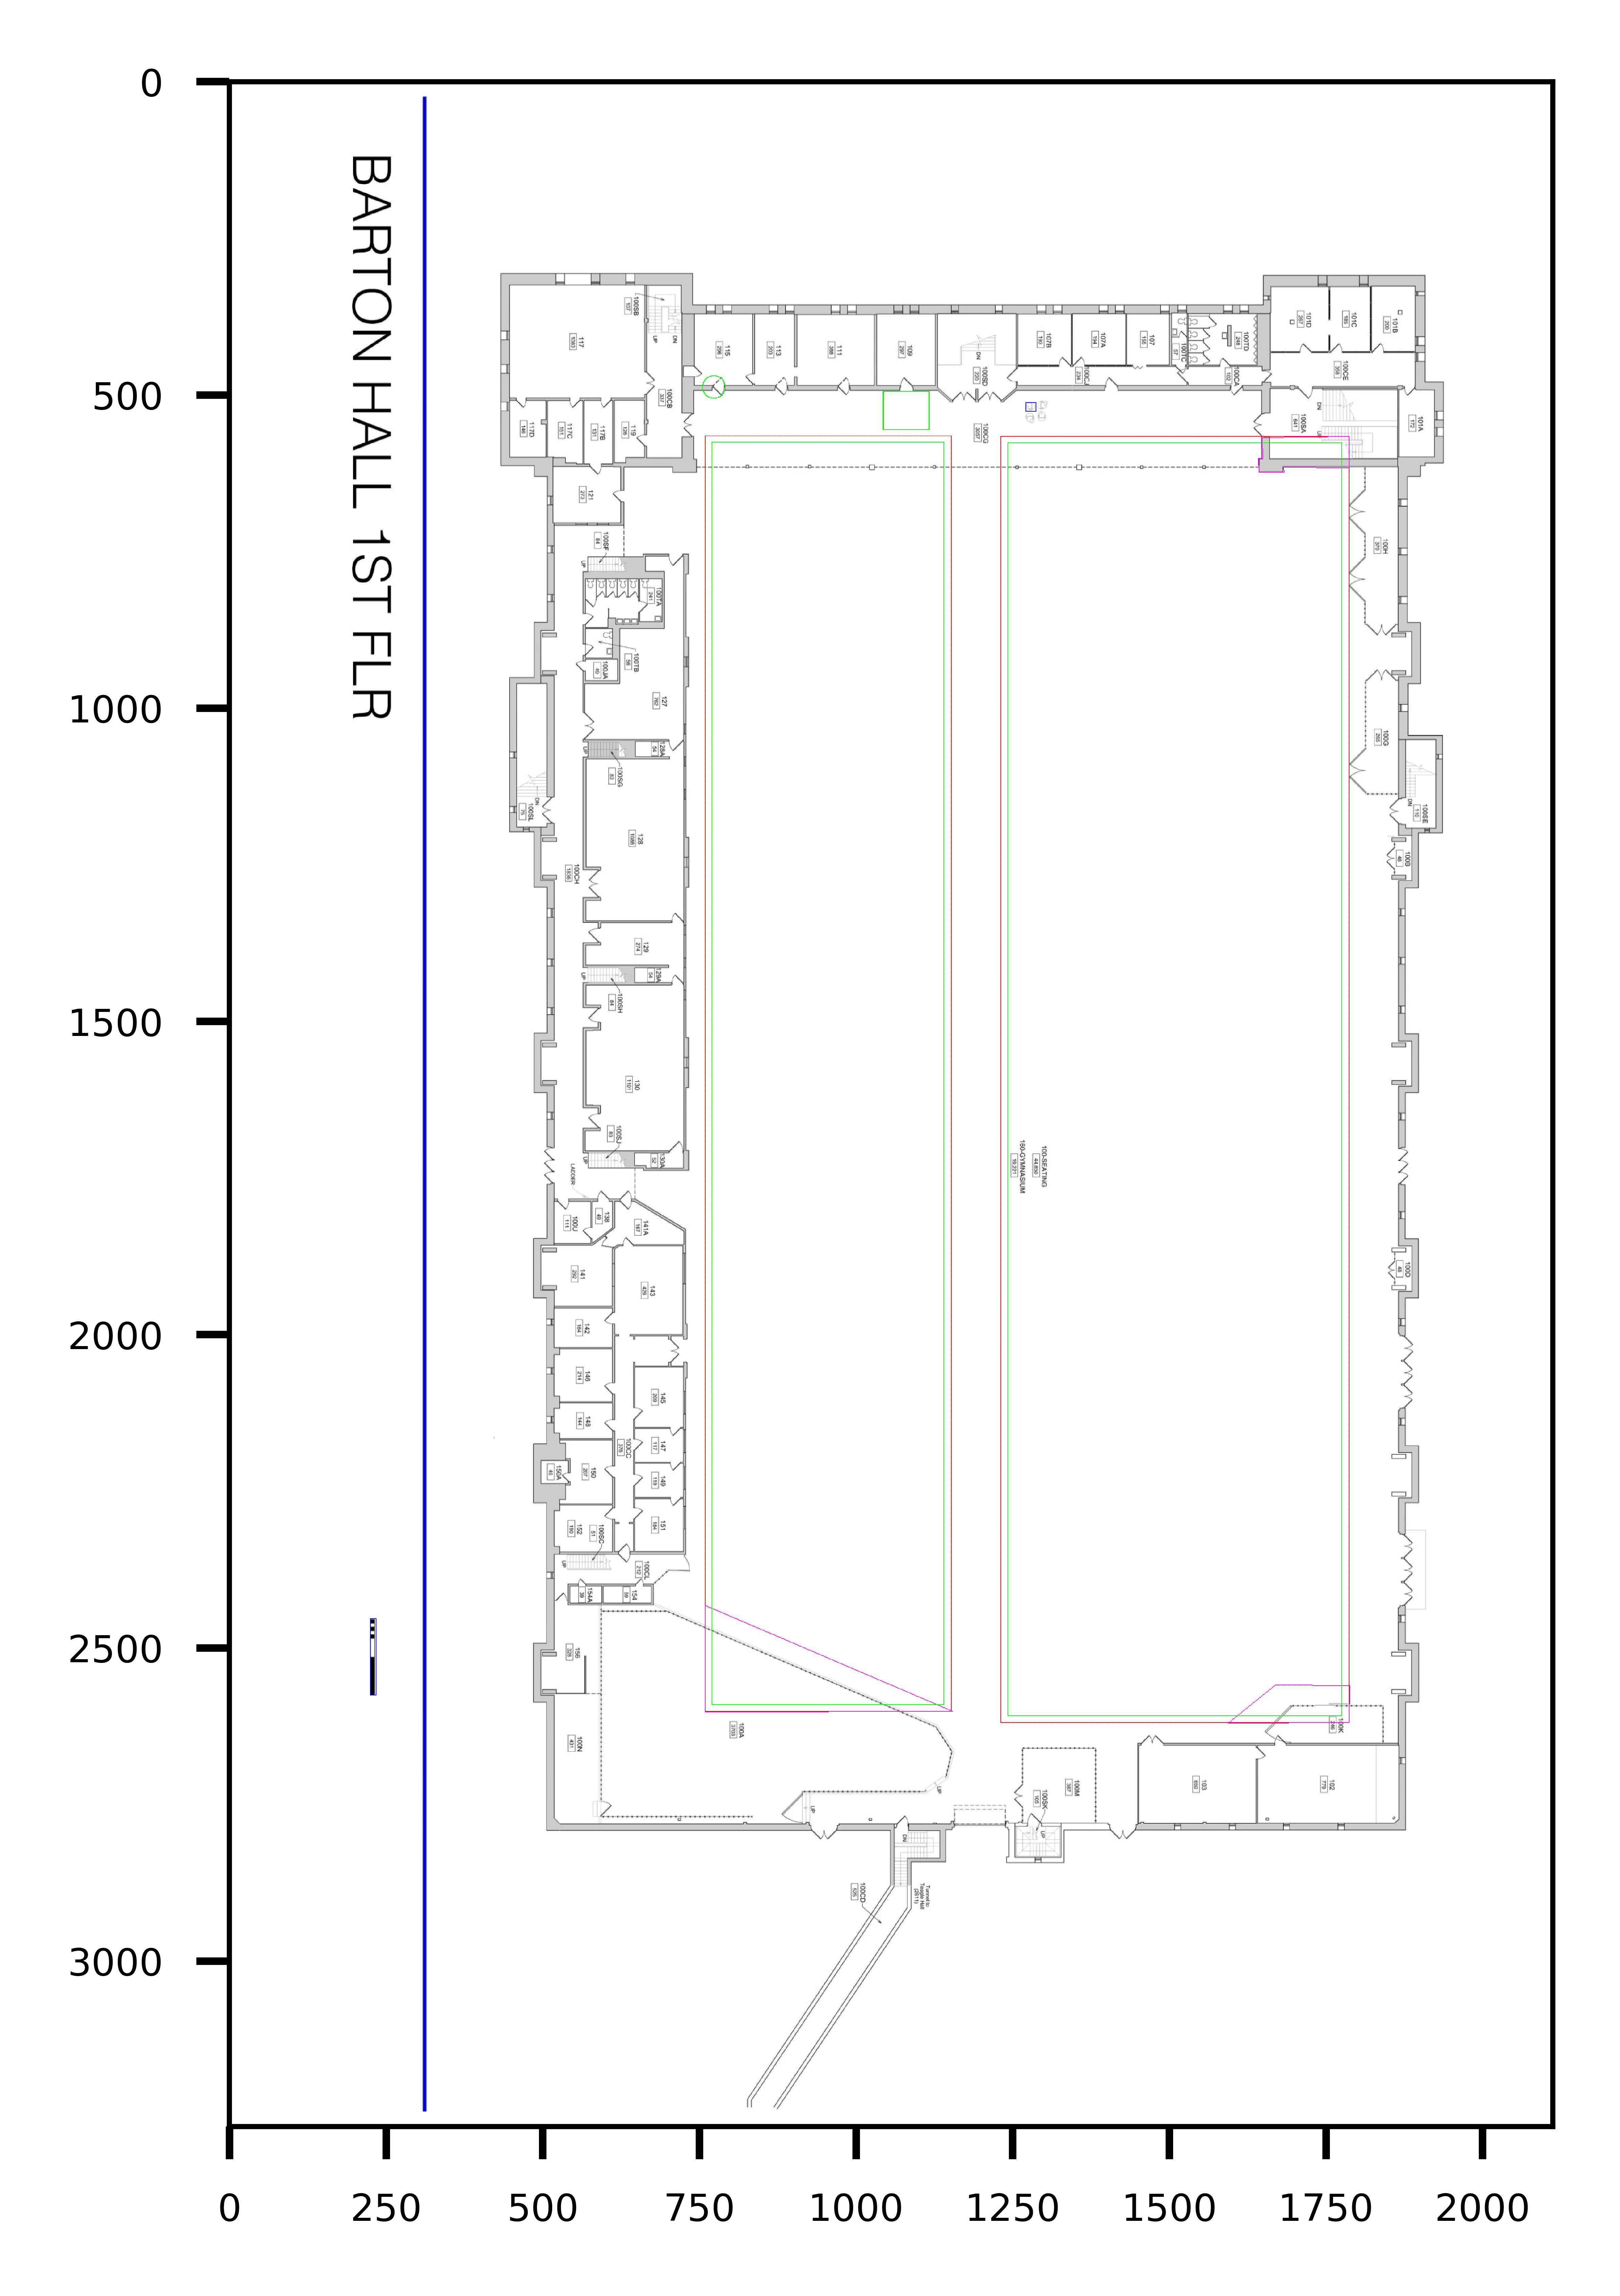

In [173]:
if Shift_Above_Teacher_Zone:
    print("Shift")
    print(nogozone)
    if t_box == 'top':
        y_edge_perimeter=(nogozone[1][1]+Polygon_Height/2,y_edge_perimeter[1])
    elif t_box == 'bottom':
        y_edge_perimeter=(y_edge_perimeter[0],nogozone[0][1]-Polygon_Height/2)
    elif t_box == 'left':
        x_edge_perimeter=(nogozone[2][0]+Polygon_Width/2,x_edge_perimeter[1])
    elif t_box == 'right':
        x_edge_perimeter=(x_edge_perimeter[0],nogozone[3][0]-Polygon_Width/2)

rect = cv2.rectangle(WritableImage, (int(x_edge_perimeter[0]),int(y_edge_perimeter[0])), (int(x_edge_perimeter[1]),int(y_edge_perimeter[1])), (0, 255, 0), 1)
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=2000)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    
PZWidth=x_edge_perimeter[1]-x_edge_perimeter[0]
PZHeight=y_edge_perimeter[1]-y_edge_perimeter[0] 

ax.imshow(WritableImage)

# Solving The Classroom
## Creating Nodes and Edges
Uses the adjusted information to come up with seating plans that attempt to maximize seats.

Places seats in a grid like pattern

In [174]:
locs=list()
polys = list()
points = list()
Chairs_x=int((PZWidth-x_factor)//((feet6+Polygon_Width/2+1)/x_factor)+1)
Chairs_y=int((PZHeight-y_factor)//((feet6+Polygon_Height/2+1)/y_factor)+1)
shape =4
for column in range(Chairs_x):
    for chair in range(Chairs_y):
        locs.append((x_edge_perimeter[0]+((feet6+Polygon_Width/2+1)/x_factor)*column,y_edge_perimeter[0]+((feet6+Polygon_Height/2+1)/y_factor)*chair))
if Rotated_Other==True:
    shape=8
for i in range(len(locs)):
    polys.append(Polygon(arr + np.array([locs[i]]*shape)))
    points.append(Point(np.array([0, 0] + np.array([locs[i][0], locs[i][1]]))))

Draw the defined possible seat locations.

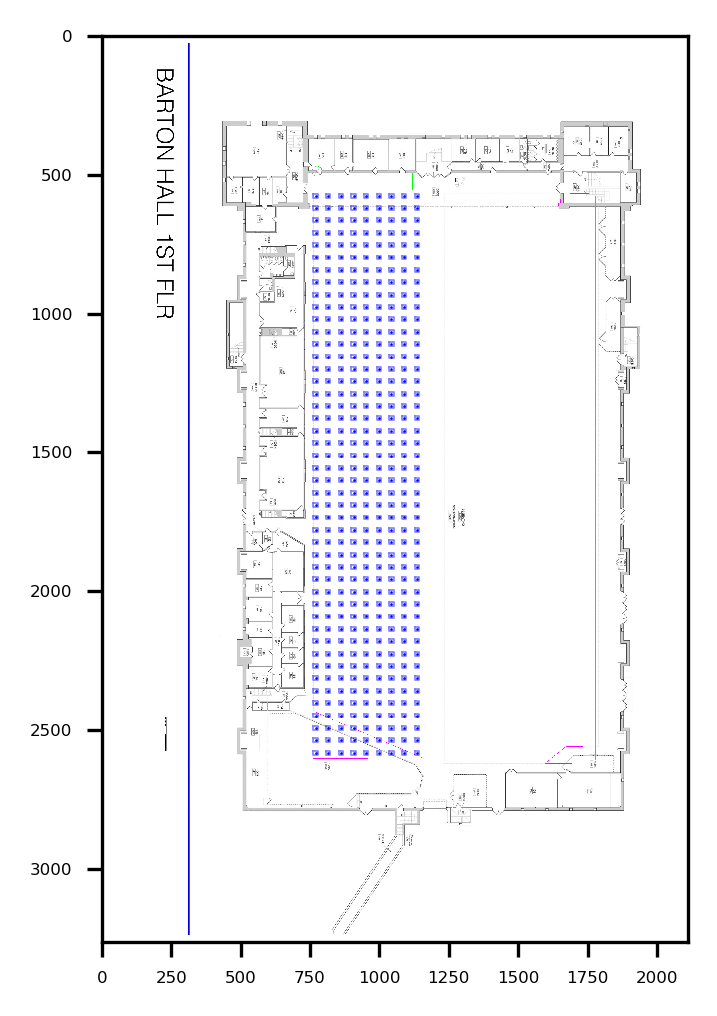

In [175]:
# plot solutions (airline seat booking style)
img = WritableImage
fig, ax = plt.subplots(dpi=300)

for i in range(len(polys)):
    x,y = polys[i].exterior.xy
    ax.plot(x, y, color='blue', alpha=0.5, linewidth=0.4, solid_capstyle='round', zorder=2)
    
# plot points    
xs = [point.x for point in points]
ys = [point.y for point in points]
plt.scatter(xs, ys, s=0.1, color='blue', alpha=1, linewidth=0.3)

ax.imshow(img)

Define a dataframe to keep track of the information.

In [176]:
# define a dataframe of Polygons and Points
df = pd.DataFrame(list(zip(polys, points)), 
               columns =['polygon', 'point'])

print('There are %d nodes.' % df.shape[0])

There are 414 nodes.


We want an adjacency list. We define two seats as adjacent if
    * The distance from the central point to the boundary of the chair is no more than feet6 pixels (6'').

In order to eliminate chairs that intersect forbidden zones (Polygons and Teacher zones), an edge (i,i) is added if
    * The polygon of the chair intersects the Polygon of the forbidden zone.

In [203]:
# generate edges from distances
edgelist = list()      # overall list of (directed) edges

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (i != j):
            dist = df['polygon'][j].distance(df['point'][i])
            if (dist <= feet6):
                edgelist.append((i,j)) # add edge if seat is too close
for i in range(df.shape[0]):
    if(df['polygon'][i].intersects(zone)):
        edgelist.append((i,i))
        
for i in range(df.shape[0]):
    for doorway in Doorways:
        if(df['polygon'][i].intersects(doorway)):
            edgelist.append((i,i))
print('There are %d edges and %d nodes.' % (len(edgelist), df.shape[0]))

There are 20 edges and 414 nodes.


## Define the network model.

For any edge between two nodes, only one of those nodes i and j, only one of i and j can be included in the final solution.
For an edge between a node and itself, either both or none of the node can be included, meaning that it automatically bans the node from the solution as the included node count for the edge is either 0 or 2 and never 1.

In [204]:
# a model for counting seats (function by Jody Zhu)

# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def miset(nodes,edges,solver):
    NODES = []
    NODES.extend(nodes)    # these four lines are not necessary
    EDGES = []             # made a copy in case the lists will be modified
    EDGES.extend(edges)
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in NODES:
        x[i] = m.IntVar(0, 1, ('%s' % (i))) 
        
    # objective function
    m.Maximize(sum(x[i] for i in NODES))
        
    # subject to: no more than 1 node from an edge
    for edge in EDGES:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    sol = {}
    for i in NODES:
        sol.update( {x[i].name() : x[i].solution_value()} )

    print('Total seats:', m.Objective().Value())
    
    return(sol)

## Solve the network model.
Solve the network model to get the maximum amount of seats that can be included.

In [205]:
# solve problem
sol = miset(df.index.values, edgelist, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 394.0


Map the solution to the dataframe.

In [206]:
# map solution to dataframe
df['index_string'] = df.index.astype(str) # get index as strings, dict is {'id': val}
df['in_solution'] = df['index_string'].map(sol)

Plot the solution

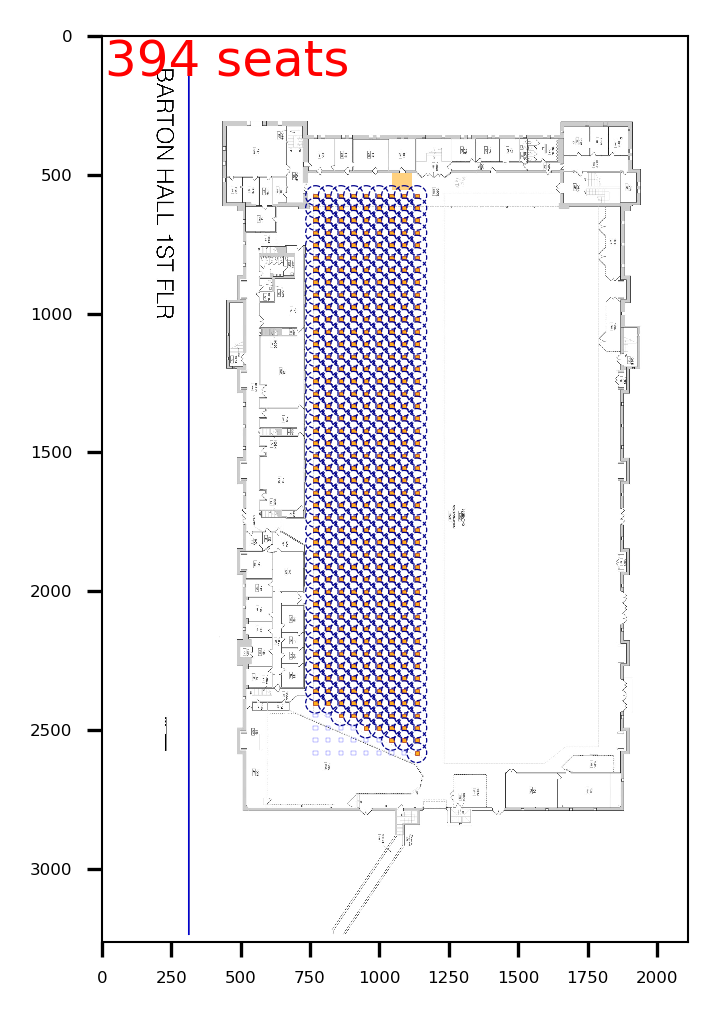

In [207]:
# plot all points to verify the matching worked
#img = plt.imread('drawings/OLH165_solved.jpg') # to see hardcoded solutions
img = cv2.imread(floor)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(df.shape[0]):
    if (df['in_solution'][i] == 1):
        xs,ys = df['polygon'][i].exterior.xy
        ax.fill(xs, ys, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)
    else:
        xs,ys=df['polygon'][i].exterior.xy
        ax.plot(xs, ys, color='blue', alpha=0.6, linewidth=0.1, solid_capstyle='round', zorder=2)
    
# plot circles
sol_ids = df[df['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((df['point'][i].x, df['point'][i].y), feet6-1, fill=False,
                         ec='darkblue', ls='--', lw=0.3, zorder=4)
    ax.add_artist(draw_circle)
    
# plot stick
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)


#draw_circle = plt.Circle((300, 200), feet6-1, fill=False,
#                         ec='darkblue', ls='--', lw=0.3, zorder=4)
#ax.add_artist(draw_circle)

seats = 0
for i in sol.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')

ax.imshow(img)
plt.savefig(solution_name+'-grid.jpg',orientation='portrait',format='jpg',dpi=1000)

# Solve Again Through Random Placement

In [208]:
locsRandom= list()

x_1 = math.ceil(x_edge_perimeter[0])
x_2 = math.floor(x_edge_perimeter[1])
y_1 = math.ceil(y_edge_perimeter[0])
y_2 = math.floor(y_edge_perimeter[1])
for place in range(chairsRandom):
    locsRandom.append((random.randint(x_1,x_2), random.randint(y_1,y_2)))

In [209]:
polysRandom = list()
pointsRandom = list()

for i in range(len(locsRandom)):
    polysRandom.append(Polygon(arr + np.array([locsRandom[i]]*shape)))
    pointsRandom.append(Point(np.array([0, 0] + np.array([locsRandom[i][0], locsRandom[i][1]]))))

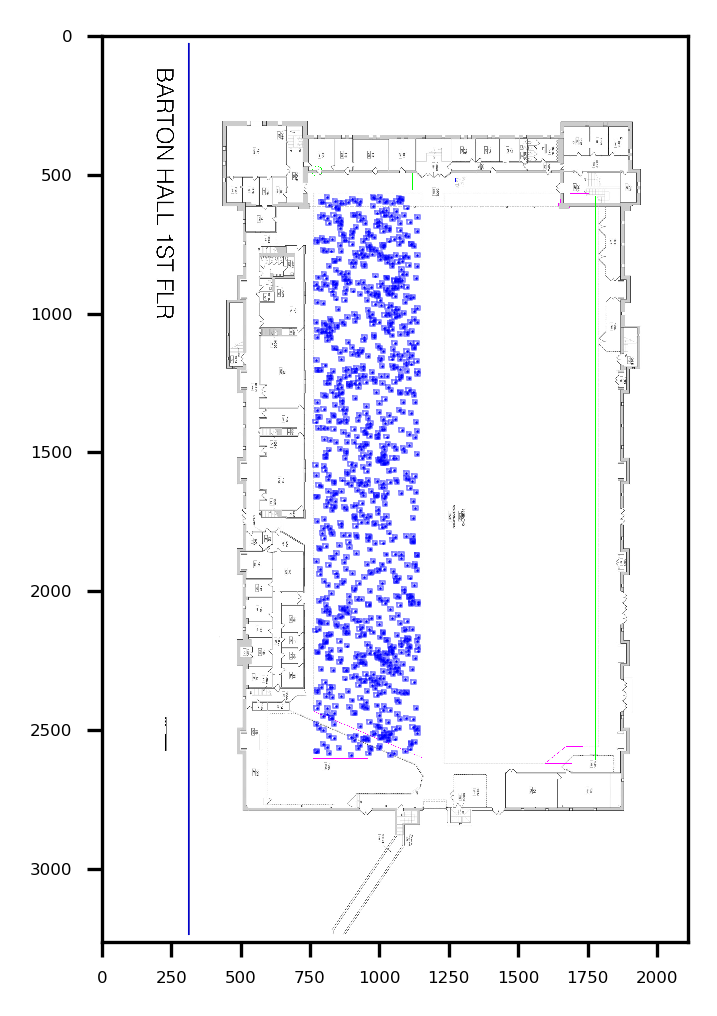

In [210]:
# plot solutions (airline seat booking style)
img = WritableImage
fig, ax = plt.subplots(dpi=300)

for i in range(len(polysRandom)):
    x,y = polysRandom[i].exterior.xy
    ax.plot(x, y, color='blue', alpha=0.5, linewidth=0.4, solid_capstyle='round', zorder=2)
    
# plot points    
xs = [point.x for point in pointsRandom]
ys = [point.y for point in pointsRandom]
plt.scatter(xs, ys, s=0.1, color='blue', alpha=1, linewidth=0.3)

ax.imshow(img)

In [211]:
# define a dataframe of Polygons and Points
dfR = pd.DataFrame(list(zip(polysRandom, pointsRandom)), 
               columns =['polygon', 'point'])

print('There are %d nodes.' % dfR.shape[0])

There are 1000 nodes.


In [212]:
# generate edges from distances
edgelistRandom = list()      # overall list of (directed) edges

for i in range(dfR.shape[0]):
    for j in range(dfR.shape[0]):
        if (i != j):
            dist = dfR['polygon'][j].distance(dfR['point'][i])
            if (dist <= feet6):
                edgelistRandom.append((i,j)) # add edge if seat is too close
for i in range(dfR.shape[0]):
    if(dfR['polygon'][i].intersects(zone)):
        edgelistRandom.append((i,i))

for i in range(dfR.shape[0]):
    for doorway in Doorways:
        if(dfR['polygon'][i].intersects(doorway)):
            edgelistRandom.append((i,i))
print('There are %d edges and %d nodes.' % (len(edgelistRandom), dfR.shape[0]))

There are 8743 edges and 1000 nodes.


In [213]:
# a model for counting seats (function by Jody Zhu)

# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def misetR(nodes,edges,solver):
    NODES = []
    NODES.extend(nodes)    # these four lines are not necessary
    EDGES = []             # made a copy in case the lists will be modified
    EDGES.extend(edges)
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in NODES:
        x[i] = m.IntVar(0, 1, ('%s' % (i))) 
        
    # objective function
    m.Maximize(sum(x[i] for i in NODES))
        
    # subject to: no more than 1 node from an edge
    for edge in EDGES:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    sol = {}
    for i in NODES:
        sol.update( {x[i].name() : x[i].solution_value()} )

    print('Total seats:', m.Objective().Value())
    
    return(sol)

In [214]:
# solve problem
solR = misetR(dfR.index.values, edgelistRandom, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 233.0


In [215]:
# map solution to dataframe
dfR['index_string'] = dfR.index.astype(str) # get index as strings, dict is {'id': val}
dfR['in_solution'] = dfR['index_string'].map(solR)

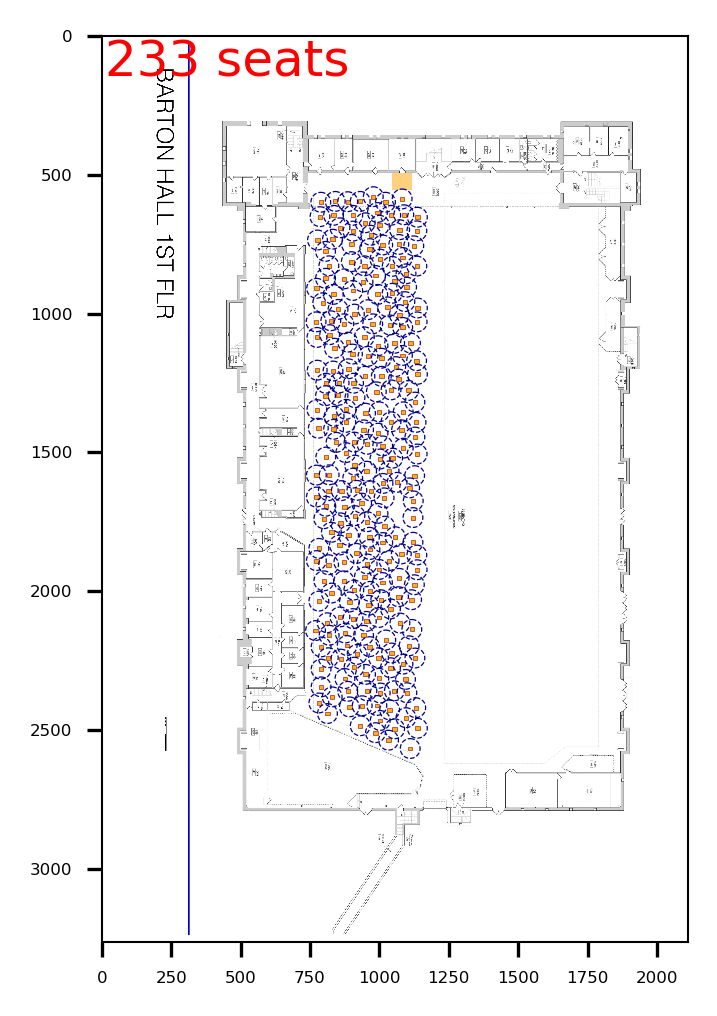

In [216]:
# plot all points to verify the matching worked
#img = plt.imread('drawings/OLH165_solved.jpg') # to see hardcoded solutions
img = cv2.imread(floor)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(dfR.shape[0]):
    if (dfR['in_solution'][i] == 1):
        xs,ys = dfR['polygon'][i].exterior.xy
        ax.fill(xs, ys, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)
    
# plot circles
sol_ids = dfR[dfR['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((dfR['point'][i].x, dfR['point'][i].y), feet6-1, fill=False,
                         ec='darkblue', ls='--', lw=0.3, zorder=4)
    ax.add_artist(draw_circle)
    
# plot stick
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)


#draw_circle = plt.Circle((300, 200), feet6-1, fill=False,
#                         ec='darkblue', ls='--', lw=0.3, zorder=4)
#ax.add_artist(draw_circle)

seats = 0
for i in solR.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')

ax.imshow(img)
plt.savefig(solution_name+'-random.jpg',orientation='portrait',format='jpg',dpi=1000)

# Solve Again Through Hexagonal Placement

In [217]:
t_box_shifter=5/3*feet6
if Shift_Above_Teacher_Zone==False:
    t_box_shifter=0

if t_box == 'top' or t_box == 'bottom':
    x_space = feet6 + 0.5*Polygon_Width + 1
    x_chairs = math.floor((x_edge[1] - x_edge[0] - Polygon_Width - x_border*feet6/3)/x_space)
    x_max = x_edge[1] - 0.5*Polygon_Width - x_border*feet6/6
    y_space = (feet6**2 - (0.5*x_space - 0.5*Polygon_Width)**2)**0.5 + 0.5*Polygon_Height + 1
    x_space2 = x_max - x_edge[0] - 0.5*Polygon_Width - x_border*feet6/6 - x_chairs*x_space
    y_space2 = (feet6**2 - (x_space2 - 0.5*Polygon_Width)**2)**0.5 + 0.5*Polygon_Height + 1
    y_chairs = math.floor((y_edge[1] - y_edge[0] - Polygon_Height - t_box_shifter - (y_border + desk_border)*feet6/6)/y_space)
    y_len = y_chairs*y_space
    y_amt = 0
    
if t_box == 'left' or t_box == 'right':
    y_space = feet6 + 0.5*Polygon_Height + 1
    y_chairs = math.floor((y_edge[1] - y_edge[0] - Polygon_Height - y_border*feet6/3)/y_space)
    y_max = y_edge[1] - 0.5*Polygon_Height - y_border*feet6/6
    x_space = (feet6**2 - (0.5*y_space - 0.5*Polygon_Height)**2)**0.5 + 0.5*Polygon_Width + 1
    y_space2 = y_max - y_edge[0] - 0.5*Polygon_Height - y_border*feet6/6 - y_chairs*y_space
    x_space2 = (feet6**2 - (y_space2 - 0.5*Polygon_Height)**2)**0.5 + 0.5*Polygon_Width + 1
    x_chairs = math.floor((x_edge[1] - x_edge[0] - Polygon_Width - t_box_shifter - (x_border + desk_border)*feet6/6)/x_space)
    x_len = x_chairs*x_space
    x_amt = 0

In [268]:
locsHex = list()

if t_box == 'top':
    y_amt = 0
    y_len = y_chairs*y_space
    for col in range(y_chairs + 1):
        if col%2 == 0:
            for row in range(x_chairs+1):
                locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + x_space*row, y_edge[0] + 0.5*Polygon_Height + t_box_shifter + desk_border*feet6/6 + y_space*(col - 2*y_amt) + y_space2*2*y_amt+1))
        else:
            if x_edge[1] - x_border*feet6/6 - 0.5*Polygon_Width >= x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*x_chairs:
                for row in range(x_chairs+1):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*row, y_edge[0] + 0.5*Polygon_Height + t_box_shifter + desk_border*feet6/6 + y_space*col+1))
            else:
                if y_len + 2*y_space2 - 2*y_space < y_edge[1] - y_edge[0] - Polygon_Height - (y_border + desk_border)*feet6/6 - t_box_shifter:
                    y_len = y_len + 2*y_space2 - 2*y_space
                    for row in range(x_chairs+1):
                        locsHex.append((x_edge[1] - 0.5*Polygon_Width - x_border*feet6/6 - x_space*row, y_edge[0] + 0.5*Polygon_Height + t_box_shifter + desk_border*feet6/6 + y_space2*(2*y_amt+1)+1))
                    y_amt += 1
                else:
                    for row in range(x_chairs):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*row, y_edge[0] + 0.5*Polygon_Height + t_box_shifter + desk_border*feet6/6 + y_space*(col - 2*y_amt) + y_space2*2*y_amt+1))

if t_box == 'bottom':
    y_amt = 0
    y_len = y_chairs*y_space
    for col in range(y_chairs + 1):
        if col%2 == 0:
            for row in range(x_chairs+1):
                locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + x_space*row, y_edge[1] - 0.5*Polygon_Height - t_box_shifter - desk_border*feet6/6 - y_space*(col - 2*y_amt) - y_space2*2*y_amt-1))
        else:
            if x_edge[1] - x_border*feet6/6 - 0.5*Polygon_Width >= x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*x_chairs:
                for row in range(x_chairs+1):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*row, y_edge[1] - 0.5*Polygon_Height - t_box_shifter - desk_border*feet6/6 - y_space*col-1))
            else:
                if y_len + 2*y_space2 - 2*y_space < y_edge[1] - y_edge[0] - Polygon_Height - (y_border + desk_border)*feet6/6 - t_box_shifter:
                    y_len = y_len + 2*y_space2 - 2*y_space
                    for row in range(x_chairs+1):
                        locsHex.append((x_edge[1] - 0.5*Polygon_Width - x_border*feet6/6 - x_space*row, y_edge[1] - 0.5*Polygon_Height - t_box_shifter - desk_border*feet6/6 - y_space2*(2*y_amt+1)-1))
                    y_amt += 1
                else:
                    for row in range(x_chairs):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + x_border*feet6/6 + 0.5*x_space + x_space*row, y_edge[1] - 0.5*Polygon_Height - t_box_shifter - desk_border*feet6/6 - y_space*(col - 2*y_amt) - y_space2*2*y_amt-1))
                        

if t_box == 'left':
    x_amt = 0
    x_len = x_chairs*x_space
    for col in range(x_chairs + 1):
        if col%2 == 0:
            for row in range(y_chairs+1):
                locsHex.append((x_edge[0] + 0.5*Polygon_Width + t_box_shifter + desk_border*feet6/6 + x_space*(col - 2*x_amt) + x_space2*2*x_amt+1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + y_space*row))
        else:
            if y_edge[1] - y_border*feet6/6 - 0.5*Polygon_Height >= y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*y_chairs:
                for row in range(y_chairs+1):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + t_box_shifter + desk_border*feet6/6 + x_space*col+1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*row))
            else:
                if x_len + 2*x_space2 - 2*x_space < x_edge[1] - x_edge[0] - Polygon_Width - (x_border + desk_border)*feet6/6 - t_box_shifter:
                    x_len = x_len + 2*x_space2 - 2*x_space
                    for row in range(y_chairs+1):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + t_box_shifter + desk_border*feet6/6 + x_space2*(2*x_amt+1)+1, y_edge[1] - 0.5*Polygon_Height - y_border*feet6/6 - y_space*row))
                    x_amt += 1
                else:
                    for row in range(y_chairs):
                        locsHex.append((x_edge[0] + 0.5*Polygon_Width + t_box_shifter + desk_border*feet6/6 + x_space*(col - 2*x_amt) + x_space2*2*x_amt+1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*row))

if t_box == 'right':
    x_amt = 0
    x_len = x_chairs*x_space
    for col in range(x_chairs + 1):
        if col%2 == 0:
            for row in range(y_chairs+1):
                locsHex.append((x_edge[1] - 0.5*Polygon_Width - t_box_shifter - desk_border*feet6/6 - x_space*(col - 2*x_amt) - x_space2*2*x_amt-1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + y_space*row))
        else:
            if y_edge[1] - y_border*feet6/6 - 0.5*Polygon_Height >= y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*y_chairs:
                for row in range(y_chairs+1):
                        locsHex.append((x_edge[1] - 0.5*Polygon_Width - t_box_shifter - desk_border*feet6/6 - x_space*col-1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*row))
            else:
                if x_len + 2*x_space2 - 2*x_space < x_edge[1] - x_edge[0] - Polygon_Width - (x_border + desk_border)*feet6/6 - t_box_shifter:
                    x_len = x_len + 2*x_space2 - 2*x_space
                    for row in range(y_chairs+1):
                        locsHex.append((x_edge[1] - 0.5*Polygon_Width - t_box_shifter - desk_border*feet6/6 - x_space2*(2*x_amt+1)-1, y_edge[1] - 0.5*Polygon_Height - y_border*feet6/6 - y_space*row))
                    x_amt += 1
                else:
                    for row in range(y_chairs):
                        locsHex.append((x_edge[1] - 0.5*Polygon_Width - t_box_shifter - desk_border*feet6/6 - x_space*(col - 2*x_amt) - x_space2*2*x_amt-1, y_edge[0] + 0.5*Polygon_Height + y_border*feet6/6 + 0.5*y_space + y_space*row))

In [269]:
x_1 = math.ceil(x_edge_perimeter[0])
x_2 = math.floor(x_edge_perimeter[1])
y_1 = math.ceil(y_edge_perimeter[0])
y_2 = math.floor(y_edge_perimeter[1])
for place in range(chairsRandomHex):
    locsHex.append((random.randint(x_1,x_2), random.randint(y_1,y_2)))

In [270]:
polysHex = list()
pointsHex = list()

for i in range(len(locsHex)):
    polysHex.append(Polygon(arr + np.array([locsHex[i]]*shape)))
    pointsHex.append(Point(np.array([0, 0] + np.array([locsHex[i][0], locsHex[i][1]]))))

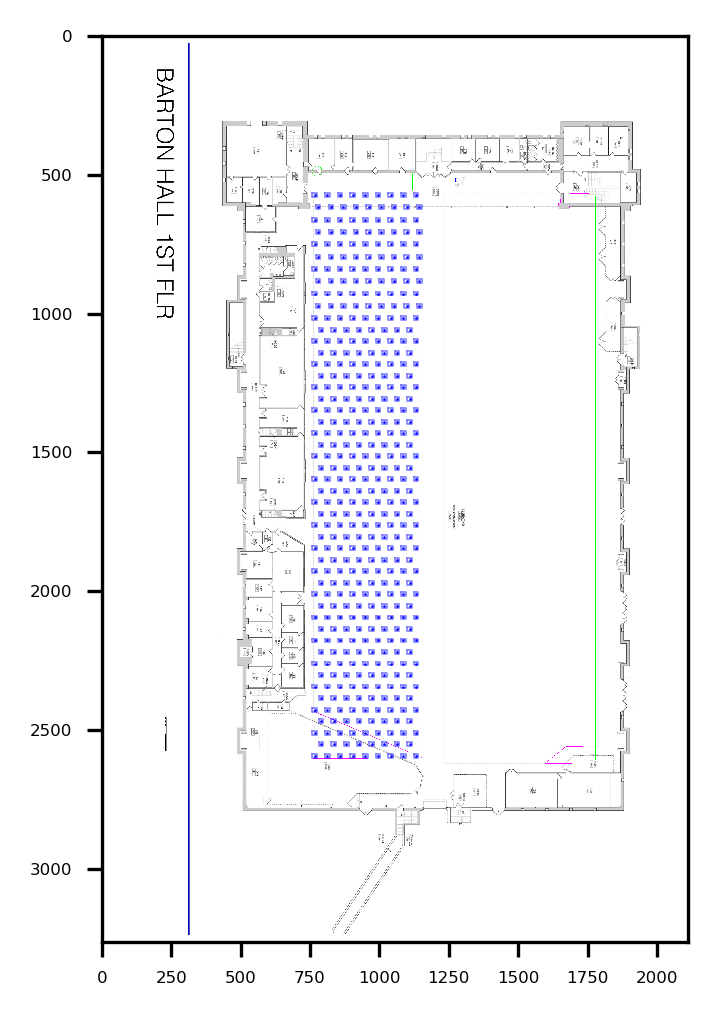

In [271]:
# plot solutions (airline seat booking style)
img = WritableImage
fig, ax = plt.subplots(dpi=300)

for i in range(len(polysHex)):
    x,y = polysHex[i].exterior.xy
    ax.plot(x, y, color='blue', alpha=0.5, linewidth=0.4, solid_capstyle='round', zorder=2)
    
# plot points    
xs = [point.x for point in pointsHex]
ys = [point.y for point in pointsHex]
plt.scatter(xs, ys, s=0.1, color='blue', alpha=1, linewidth=0.3)

ax.imshow(img)

In [272]:
# define a dataframe of Polygons and Points
dfH = pd.DataFrame(list(zip(polysHex, pointsHex)), 
               columns =['polygon', 'point'])

print('There are %d nodes.' % dfH.shape[0])

There are 422 nodes.


In [273]:
# generate edges from distances
edgelistHex = list()      # overall list of (directed) edges

for i in range(dfH.shape[0]):
    for j in range(dfH.shape[0]):
        if (i != j):
            dist = dfH['polygon'][j].distance(dfH['point'][i])
            if (dist <= feet6):
                edgelistHex.append((i,j)) # add edge if seat is too close
for i in range(dfH.shape[0]):
    if(dfH['polygon'][i].intersects(zone)):
        edgelistHex.append((i,i))
for i in range(dfH.shape[0]):
    for doorway in Doorways:
        if(dfH['polygon'][i].intersects(doorway)):
            edgelistHex.append((i,i))
print('There are %d edges and %d nodes.' % (len(edgelistHex), dfH.shape[0]))

There are 23 edges and 422 nodes.


In [274]:
# a model for counting seats (function by Jody Zhu)

# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def misetH(nodes,edges,solver):
    NODES = []
    NODES.extend(nodes)    # these four lines are not necessary
    EDGES = []             # made a copy in case the lists will be modified
    EDGES.extend(edges)
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in NODES:
        x[i] = m.IntVar(0, 1, ('%s' % (i))) 
        
    # objective function
    m.Maximize(sum(x[i] for i in NODES))
        
    # subject to: no more than 1 node from an edge
    for edge in EDGES:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    sol = {}
    for i in NODES:
        sol.update( {x[i].name() : x[i].solution_value()} )

    print('Total seats:', m.Objective().Value())
    
    return(sol)

In [275]:
# solve problem
solH = misetH(dfH.index.values, edgelistHex, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 399.0


In [276]:
# map solution to dataframe
dfH['index_string'] = dfH.index.astype(str) # get index as strings, dict is {'id': val}
dfH['in_solution'] = dfH['index_string'].map(solH)

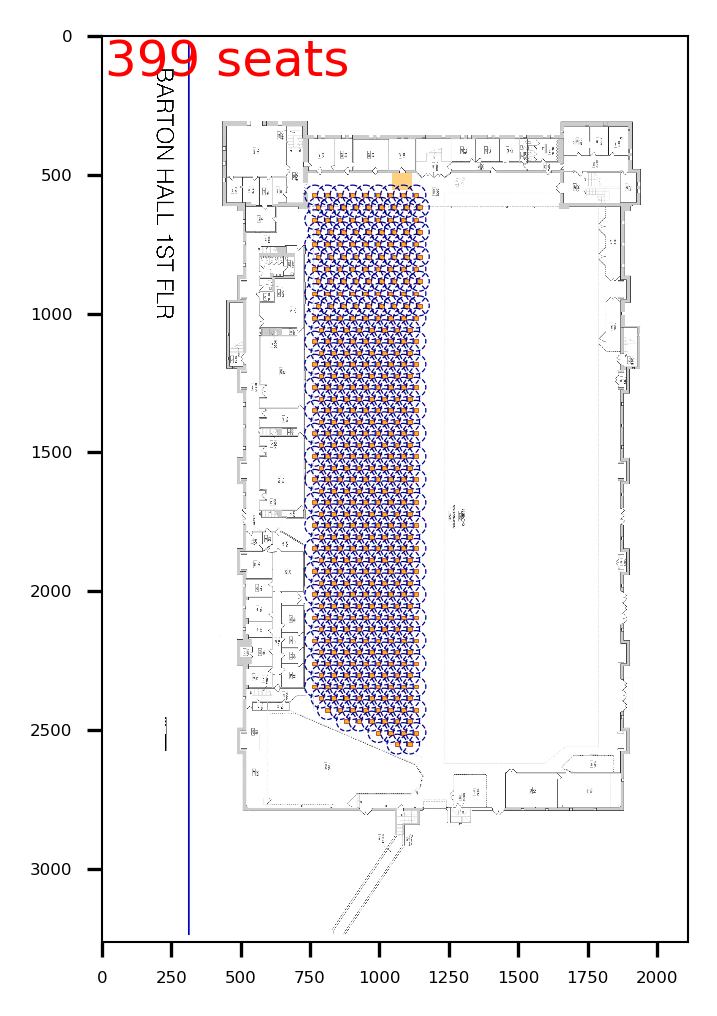

In [277]:

#img = plt.imread('drawings/OLH165_solved.jpg') # to see hardcoded solutions
img = cv2.imread(floor)
ax.imshow(img)
# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(dfH.shape[0]):
    if (dfH['in_solution'][i] == 1):
        xs,ys = dfH['polygon'][i].exterior.xy
        ax.fill(xs, ys, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)
    
# plot circles
sol_ids = dfH[dfH['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((dfH['point'][i].x, dfH['point'][i].y), feet6-1, fill=False,
                         ec='darkblue', ls='--', lw=0.3, zorder=4)
    ax.add_artist(draw_circle)
    
# plot stick
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)


#draw_circle = plt.Circle((300, 200), feet6-1, fill=False,
#                         ec='darkblue', ls='--', lw=0.3, zorder=4)
#ax.add_artist(draw_circle)

seats = 0
for i in solH.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')

ax.imshow(img)
plt.savefig(solution_name+'-hex.jpg',orientation='portrait',format='jpg',dpi=1000)